In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn

import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import tensorflow as tf
import gc
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
test_df = pd.read_csv('twitter_validation.csv', header=None)
train_df = pd.read_csv('twitter_training.csv',header=None)
test_df.reset_index(drop=True,inplace=True)
train_df.reset_index(drop=True,inplace=True)
df = pd.concat([train_df,test_df], axis=0)
df.drop([0], axis=1, inplace=True)
df.columns = ['platform','sentiment','text']
df.drop(['platform'], axis=1, inplace=True)
df.sentiment = df.sentiment.map({"Neutral":0, "Irrelevant":0 ,"Positive":1,"Negative":2})
df.dropna(inplace=True)

In [3]:
def data_preprocessing(text):
    text = text.lower()
    text = re.sub(r'https?://www\.\S+\.cm', '', text)
    text = re.sub(r'[^a-zA-Z|\s]', '', text)
    text = re.sub(r'\*+', 'swear', text)
    text = re.sub('<.*?>', '', text) # Remove HTML from text
    text = re.sub(r'(.)\1{3,}', r'\1', text)
    return text

df['text'] = df['text'].astype(str).apply(lambda x:data_preprocessing(x))
df.head()

,sentiment,text
0,1,im getting on borderlands and i will murder yo...
1,1,i am coming to the borders and i will kill you...
2,1,im getting on borderlands and i will kill you all
3,1,im coming on borderlands and i will murder you...
4,1,im getting on borderlands and i will murder y...


In [4]:
class Dataset:
    def __init__(self,text,sentiment):
        self.text = text
        self.sentiment = sentiment
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item,:]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }

In [5]:
def load_vectors(fname):
    fin = open(fname)
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])
        
    return data

def create_embedding_matrix(word_index,embedding_dict):
    """
    This function creates the embedding matrix
    :param word_index: a dictionary of word: index_value
    :param embedding_dict:
    :return a numpy array with embedding vectors for all known words
    """
    # intialize the embedding matrix 
    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
    return embedding_matrix

In [6]:
class sentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, embedding_matrix, hidden_dim, output_size):
        """
        Initialize the model by setting up the layers.
        """
        super(sentimentLSTM, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=num_words,embedding_dim=embed_dim)
        ## initializes the weights of the embedding layer to the pretrained embeddings in 
        ## embedding_matrix. It first converts embedding_matrix to a PyTorch tensor and 
        ## wraps it in an nn.Parameter object, which makes it a learnable parameter of the model.
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_size)
        
    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm1(embeds)
        lstm_out = self.dropout(lstm_out)  # Apply dropout after the first LSTM layer
        lstm_out, _ = self.lstm2(lstm_out)  # Pass the output of the first LSTM layer as input to the second
        # We only take the output from the last time step
        lstm_out = lstm_out[:, -1]
        out = self.fc(lstm_out)
        return out

In [7]:
y = df.sentiment.values
train_df, tem_df = train_test_split(df, test_size = 0.3, random_state=42,stratify = y)

y_tem = tem_df.sentiment.values
valid_df, test_df = train_test_split(tem_df, test_size=0.5, random_state=42, stratify=y_tem)

In [8]:
MAX_LEN = max([len(x.split()) for x in df['text']])
BATCH_SIZE = 16

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.text.values.tolist())

xtrain = tokenizer.texts_to_sequences(train_df.text.values)
xvalid = tokenizer.texts_to_sequences(valid_df.text.values)
xtest = tokenizer.texts_to_sequences(test_df.text.values)

xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
xvalid = tf.keras.preprocessing.sequence.pad_sequences(xvalid,maxlen = MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)

train_dataset = Dataset(text=xtrain,sentiment=train_df.sentiment.values)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)

valid_dataset = Dataset(text=xvalid,sentiment=valid_df.sentiment.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)

test_dataset = Dataset(text=xtest,sentiment=test_df.sentiment.values)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)

In [9]:
embedding_dict = load_vectors('glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)

In [10]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    # set init values 
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data in train_loader:
        inputs = data['text']
        labels = data['target']
        # start CPU
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)
        model.zero_grad()
        output = model(inputs)
        # calculate the batch loss
        loss = criterion(output, labels.long())
                # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Calculate Accuracy
        accuracy = (output.argmax(dim=1) == labels).float().mean()
        # update training loss and accuracy
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        optimizer.step()
    return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)
    
def validate_one_epoch(model, valid_loader, criterion, device):
    # set init values
    valid_loss = 0.0
    valid_accuracy = 0.0
    ######################
    # validate the model #
    ######################
    model.eval()
    for data in valid_loader:
        inputs = data['text']
        labels = data['target']
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)
        with torch.no_grad():
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the batch loss
            loss = criterion(output, labels.long())
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == labels).float().mean()
            # update average validation loss and accuracy
            valid_loss += loss.item()
            valid_accuracy += accuracy.item()
    return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

def evaluate(model, test_loader, criterion, device):
    # set init values
    test_loss = 0.0
    test_accuracy = 0.0
    all_preds = []
    all_targets = []
    ######################
    # evaluate the model #
    ######################
    model.eval()
    for data in test_loader:
        inputs = data['text']
        labels = data['target']
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)
        with torch.no_grad():
            # turn off gradients for evaluation
            output = model(inputs)
            # calculate the batch loss
            loss = criterion(output, labels.long())
            # calculate accuracy
            accuracy = (output.argmax(dim=1) == labels).float().mean()
            # update average test loss and accuracy
            test_loss += loss.item()
            test_accuracy += accuracy.item()
            preds = output.argmax(dim=1)
            # get prediction and true values
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    # calculate average losses
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    return test_loss, test_accuracy, np.array(all_preds), np.array(all_targets)

In [11]:
def fit(
        model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
    ):
        # set init values
        valid_loss_min = np.Inf
        train_losses = []
        valid_losses = []
        train_accs = []
        valid_accs = []
        # set the logic about epoch
        for epoch in range(1, epochs + 1):
            # clear useless data
            gc.collect()

            print(f"{'='*50}")
            print(f"EPOCH {epoch} - TRAINING...")
            train_loss, train_acc = train_one_epoch(model,
                train_loader, criterion, optimizer, device
            )
            print(
                f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
            )
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            gc.collect()

            if valid_loader is not None:
                gc.collect()
            
                print(f"EPOCH {epoch} - VALIDATING...")
                valid_loss, valid_acc = validate_one_epoch(model,
                    valid_loader, criterion, device
                )
                print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
                valid_losses.append(valid_loss)
                valid_accs.append(valid_acc)
                gc.collect()

                # show if validation loss has decreased
                if valid_loss <= valid_loss_min and epoch != 1:
                    print(
                        "Validation loss decreased ({:.4f} --> {:.4f}).".format(
                            valid_loss_min, valid_loss
                        )
                    )
                valid_loss_min = valid_loss

        return {
            "train_loss": train_losses,
            "valid_loss": valid_losses,
            "train_acc": train_accs,
            "valid_acc": valid_accs,
        }

In [12]:
device = torch.device("cpu")
hidden_dim = 64
output_size = 3
model = sentimentLSTM(embedding_matrix, hidden_dim, output_size)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
criterion = nn.CrossEntropyLoss()

# record start time
print(f"INITIALIZING TRAINING ")
start_time = datetime.now()
print(f"Start Time: {start_time}")
# train model
logs = fit(
    model=model,
    epochs=10,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

INITIALIZING TRAINING 
Start Time: 2024-04-06 17:13:41.240559
EPOCH 1 - TRAINING...

	[TRAIN] EPOCH 1 - LOSS: 0.8457984856191622, ACCURACY: 0.6027125876257239

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 0.7478193933221049, ACCURACY: 0.6660739687055477

EPOCH 2 - TRAINING...

	[TRAIN] EPOCH 2 - LOSS: 0.6615851089717121, ACCURACY: 0.7172927461139896

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 0.627683848948092, ACCURACY: 0.7348862019914651

Validation loss decreased (0.7478 --> 0.6277).
EPOCH 3 - TRAINING...

	[TRAIN] EPOCH 3 - LOSS: 0.5173420734460562, ACCURACY: 0.7897554099359951

EPOCH 3 - VALIDATING...
	[VALID] LOSS: 0.5314352204374025, ACCURACY: 0.7828058321479374

Validation loss decreased (0.6277 --> 0.5314).
EPOCH 4 - TRAINING...

	[TRAIN] EPOCH 4 - LOSS: 0.408582463270097, ACCURACY: 0.8378352636391344

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 0.49691932770300384, ACCURACY: 0.8031650071123755

Validation loss decreased (0.5314 --> 0.4969).
EPOCH 5 - TRAINING...

	[TRAIN] EPOCH 5 - LOSS: 0.

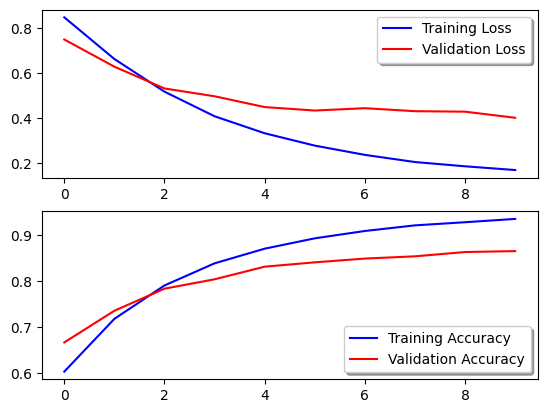

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(logs['train_loss'], color='b', label="Training Loss")
ax[0].plot(logs['valid_loss'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(logs['train_acc'], color='b', label="Training Accuracy")
ax[1].plot(logs['valid_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [14]:
test_loss, test_acc, all_preds, all_targets = evaluate(model, test_loader, criterion, device)
print(f"\t[TEST] LOSS: {test_loss}, ACCURACY: {test_acc}\n")

	[TEST] LOSS: 0.42479956561102034, ACCURACY: 0.8600640113798008



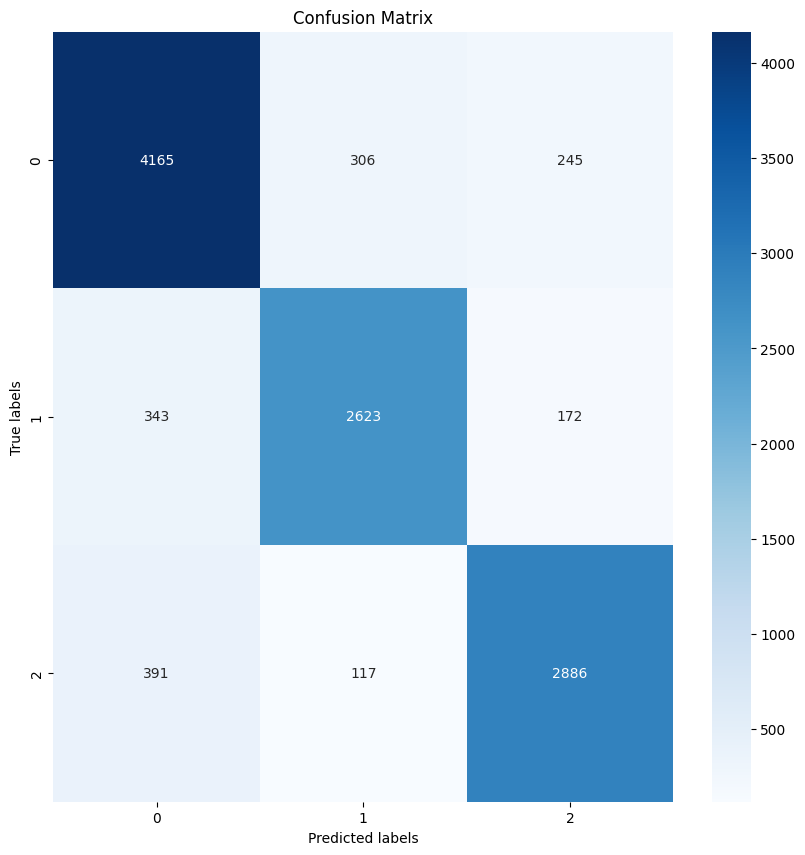

In [15]:
# Calculate confusion matrix
conf_mat = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(10, 10))
# plot it
sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [16]:
# make performance metrics for each classes
accuracy = accuracy_score(all_targets, all_preds)
print(accuracy)

0.8600640113798008


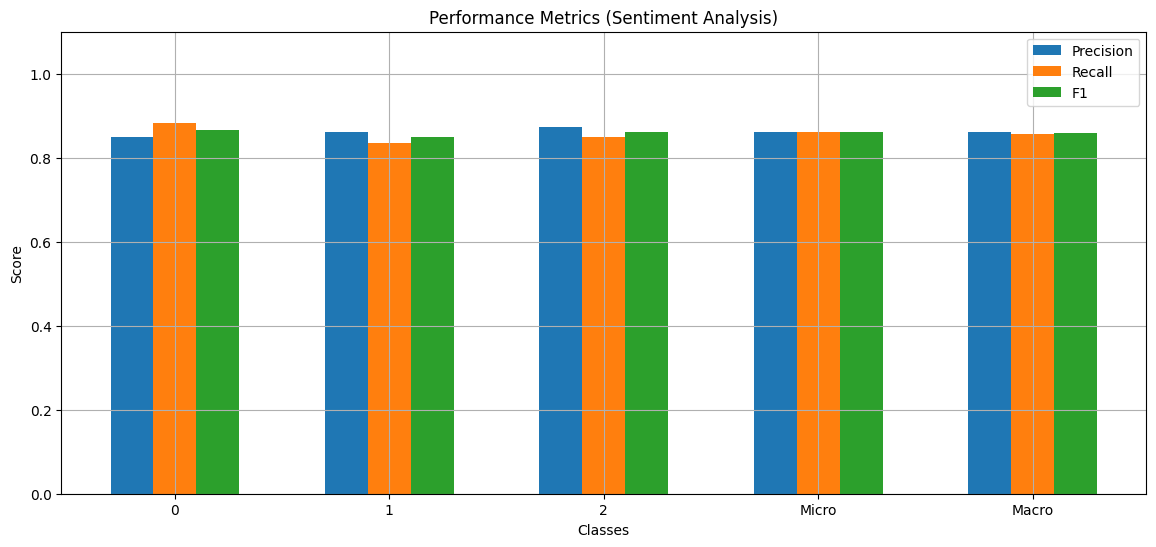

In [17]:
# define the values in normal, micro and macro state
num_classes = 3

precision = precision_score(all_targets, all_preds, average=None)
precision_micro = precision_score(all_targets, all_preds, average='micro')
precision_macro = precision_score(all_targets, all_preds, average='macro')

recall = recall_score(all_targets, all_preds, average=None)
recall_micro = recall_score(all_targets, all_preds, average='micro')
recall_macro = recall_score(all_targets, all_preds, average='macro')

f1 = f1_score(all_targets, all_preds, average=None)
f1_micro = f1_score(all_targets, all_preds, average='micro')
f1_macro= f1_score(all_targets, all_preds, average='macro')

precision = np.append(precision, [precision_micro, precision_macro])
recall = np.append(recall, [recall_micro, recall_macro])
f1 = np.append(f1, [f1_micro, f1_macro])
classes = list(range(num_classes)) + ['Micro', 'Macro']

x = np.arange(len(classes))
width = 0.2

fig1, ax1 = plt.subplots(figsize=(14, 6))
rects1 = ax1.bar(x - width, precision, width, label='Precision')
rects2 = ax1.bar(x, recall, width, label='Recall')
rects3 = ax1.bar(x + width, f1, width, label='F1')

ax1.set_xlabel('Classes')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics (Sentiment Analysis)')
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.set_ylim(0, 1.1)
ax1.legend(loc='upper right')
ax1.grid(True)
plt.show()